In [557]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

import os

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

%reload_ext autoreload
%autoreload 2

# set plot properties to seaborn globally
plt.style.use("seaborn-v0_8-white")

In [558]:
## importing the description of the attributes as a dictionary

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

current_dir = os.getcwd()
raw_data_dir = current_dir + "/raw_data/"

xls = pd.ExcelFile(raw_data_dir + 'LCDataDictionary.xlsx')
#print(xls.sheet_names)  #to see available sheets

# descriptions of the data columns are in the 'LoanStats' sheet
loan_data_desc = xls.parse('LoanStats')

# drop unnecessary rows that does not have a description in the description df
loan_data_desc.dropna(inplace = True)

# replace a weird looking one: total_rev_hi_lim \xa0
loan_data_desc.LoanStatNew = loan_data_desc.LoanStatNew.str.replace(r'\s+', '', regex=True)

# turn into a simple dictionary for easy access to column descriptions
col_desc_dict = loan_data_desc.set_index('LoanStatNew')['Description'].to_dict()

-----
### **1. Probability of Default (PD) Model**
------

#### **1.1 PD Model: Logistic Regression**
------

In [559]:
# Load the preprocessed data: Clean, binned and dummified

model_data_dir = current_dir + "/model_data/" 

loan_Xt = pd.read_csv(model_data_dir + 'loan_data_train_pp.csv', index_col = 0)
loan_Xval = pd.read_csv(model_data_dir + 'loan_data_val_pp.csv', index_col = 0)

loan_yt = pd.read_csv(model_data_dir + 'loan_data_target.csv', index_col = 0)
loan_yval = pd.read_csv(model_data_dir + 'loan_data_target_val.csv', index_col = 0)

reference_bins = pd.read_csv(model_data_dir + 'reference_bins.csv', index_col = 0)

Recall that the dummified data has collinearity issue within the categories of each variable, so we should drop the ones we identified as the reference category. Since we have performed binning based on `WoE`, the natural choice for the reference bins is the ones with the minimum `WoE` (higher probability of default). 

To avoid the dummy trap, we will drop the reference category from our training and validation sets. We will use the reference category as a benchmark! 

In [525]:
reference_bins

,Variable,Opt_Ref_Bin
0,home_ownership,['OTHER' 'NONE' 'RENT']
1,verification_status,['Verified']
2,purpose,['small_business' 'educational' 'moving' 'house' 'other'\n 'renewable_energy' 'medical']
3,addr_state,['NE' 'IA' 'NV' 'FL' 'HI' 'AL']
4,initial_list_status,['f']
5,inq_last_6mths,"[2.50, inf)"
6,emp_length_years,"(-inf, 0.50)"
7,term_in_months,"[48.00, inf)"
8,total_rev_hi_lim_missing,"[0.50, inf)"
9,tot_coll_amt_missing,"[0.50, inf)"


In [560]:
reference_cols = ['home_ownership:OTHER-NONE-RENT', 'verification_status:Verified'
                  ,'purpose:small_business-educational-moving-house-other-renewable_energy-medical'
                  ,'addr_state:NE-IA-NV-FL-HI-AL'
                  ,'initial_list_status:f', 'inq_last_6mths:3-33', 'emp_length:0'
                  ,"term_in_months:60", 'annual_inc:<37038.50'
                  ,'dti:>26.44', 'revol_util:>89.75', 'tot_cur_bal:<81646.00'
                  ,'total_rev_hi_lim:<22825.00'
                  ,'total_acc:<10.50'
                  ,'mths_since_earliest_cr_line:<89.50'
                  ,'inqlast6mths_x_dti:>45.13'
                  ,'loan_to_income:>0.33'
                  ]

In [561]:
loan_Xt = loan_Xt.drop(reference_cols, axis = 1)
loan_Xval = loan_Xval.drop(reference_cols, axis = 1)

In [562]:
correlation_matrix = loan_Xt.corr(method='pearson')

# Keep only lower triangle (excluding diagonal)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k = 0)
lower_triangle = correlation_matrix.mask(mask)

# Filter pairs with high correlation (e.g., > 0.8)
high_corr_pairs = lower_triangle.where(lower_triangle.abs() > 0.5).stack().reset_index()
high_corr_pairs.columns = ['var_1', 'var_2', 'corr']

In [428]:
high_corr_pairs

,var_1,var_2,corr
0,purpose:wedding-vacation-debt_consolidation,purpose:car-credit_card,-0.677186
1,inq_last_6mths:1,inq_last_6mths:0,-0.645266
2,emp_length:10,emp_length:1-9,-0.770376
3,tot_cur_bal_missing,tot_coll_amt_missing,1.000000
4,inqlast6mths_x_dti:<8.99,inq_last_6mths:0,0.900540
5,inqlast6mths_x_dti:<8.99,inq_last_6mths:1,-0.516381
6,inqlast6mths_x_dti:17.04-45.13,inq_last_6mths:0,-0.575026
7,inqlast6mths_x_dti:17.04-45.13,inqlast6mths_x_dti:<8.99,-0.638534


Negative correlation within the categories of variables is expected and actually carries some information, of course we are not going to do anything about them. We are more interested in accidental multi-collinearity. The last row above tells us that `tot_cur_bal_missing` flag variable is perfectly correlated with `tot_coll_amt_missing`. Since we do not use the original variable associated with the latter in our model, we will keep the former which will carry more meaning together with the `tot_cur_bal` variable.  

In [563]:
loan_Xt = loan_Xt.drop('tot_coll_amt_missing', axis = 1)
loan_Xval = loan_Xval.drop('tot_coll_amt_missing', axis = 1)

In [565]:
# Dropping noisy attributes based on IV

more_drop = ['total_acc:10.50-14.50', 'total_acc:14.50-21.50', 'total_acc:21.50-25.50', 'total_acc:25.50-33.50','total_acc:>33.50']
more_drop2 = ['emp_length:1-9', 'emp_length:10']
#more_drop3 = ['addr_state:AR-MI-PA-OH',
#       'addr_state:AZ-NJ', 'addr_state:CA-UT-KY', 'addr_state:GA-WA-OR-WI',
#       'addr_state:IL-CT', 'addr_state:KS-SC-CO-VT-AK-MS-WV-NH-WY-DC-ME-ID',
#       'addr_state:LA-MD-NC', 'addr_state:MN-RI-MA-DE-SD-IN',
#       'addr_state:MT-TX', 'addr_state:NM-VA-NY-OK-TN-MO']

loan_Xt = loan_Xt.drop(more_drop, axis = 1)
loan_Xval = loan_Xval.drop(more_drop, axis = 1)

In [566]:
loan_Xt = loan_Xt.drop(more_drop2, axis = 1)
loan_Xval = loan_Xval.drop(more_drop2, axis = 1)

In [567]:
# drop the interaction terms: they help for identifying defaults
# but also significantly reduce the number of approved loans 

int_drop = ['inqlast6mths_x_dti:<8.99', 'inqlast6mths_x_dti:8.99-17.04', 'inqlast6mths_x_dti:17.04-45.13']
#'loan_to_income:0.16-0.26', 'loan_to_income:0.26-0.33']

loan_Xt = loan_Xt.drop(int_drop, axis = 1)
#
loan_Xval = loan_Xval.drop(int_drop, axis = 1)

#### **Model Estimation**
------

Recall that the data we are working with has approximately 90 to 10 percent class imbalance in the target value. This would make the Logistic regression model perform badly. There are several ways one we can circumvent this issue: 

1. SMOTE (Synthetic Minority Oversampling Technique): Applied to data to change its distribution
2. Class weighting: Applied to the model in order to make the model give more "attention" to the minority class and learn their features. 

Here, I will go with the second choice which is much easier to implement (and has some advantages over the former). Since we are also interested in the significance of the coefficients of the model, we are going to use `GLM` (generalized linear models) from `statsmodels` library in order to reach the coefficient `p-values` in a multi-variate setting. In contrast, `LogisticRegression()` from `sklearn` do not provide multi-variate `p-values`even in the absence of class weighting. So if the aim in inference `statsmodels` is always a better option while for predictive power, one can utilize `LogisticRegression()` to combine class weighting with regularization methods such as `L1` and `L2` that aim to help for feature selection and model stability.  

In [568]:
from models import LogisticReg_with_pvalues

lr_model = LogisticReg_with_pvalues()

lr_model.fit(loan_Xt, loan_yt)

lr_model.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               373028
Model:                            GLM   Df Residuals:                   372974
Model Family:                Binomial   Df Model:                           53
Link Function:                 Probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4279e+05
Date:                Mon, 16 Jun 2025   Deviance:                   4.8558e+05
Time:                        21:40:25   Pearson chi2:                 3.73e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08110
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -1.6722      0.017    -96.755      0.000      -1.706      -1.638
home_ownership:MORTGAGE-ANY                        0.0818      0.006     14.366      0.000       0.071       0.093
home_ownership:OWN                                 0.0662      0.008      8.374      0.000       0.051       0.082
verification_status:Not-Verified                   0.1200      0.006     21.233      0.000       0.109       0.131
verification_status:Source-Verified                0.0958      0.005     18.609      0.000       0.086       0.106
purpose:car-credit_card                            0.3706      0.008     44.925      0.000       0.354       0.387
purpose:home_improvement-major_purchase            0.2238      0.010     21.777      0.000       0.204       0.244
purpose:wedding-vacation-debt_consolidation        0.2300      0.007     31.293      0.000       0.216       0.244
addr_state:AR-MI-PA-OH                             0.1101      0.009     11.824      0.000       0.092       0.128
addr_state:AZ-NJ                                   0.0438      0.011      4.114      0.000       0.023       0.065
addr_state:CA-UT-KY                                0.0443      0.008      5.349      0.000       0.028       0.061
addr_state:GA-WA-OR-WI                             0.1330      0.010     13.378      0.000       0.114       0.153
addr_state:IL-CT                                   0.1768      0.011     15.635      0.000       0.155       0.199
addr_state:KS-SC-CO-VT-AK-MS-WV-NH-WY-DC-ME-ID     0.2489      0.011     22.915      0.000       0.228       0.270
addr_state:LA-MD-NC                                0.0350      0.011      3.314      0.001       0.014       0.056
addr_state:MN-RI-MA-DE-SD-IN                       0.0794      0.011      7.527      0.000       0.059       0.100
addr_state:MT-TX                                   0.1442      0.010     14.403      0.000       0.125       0.164
addr_state:NM-VA-NY-OK-TN-MO                       0.0309      0.008      3.714      0.000       0.015       0.047
initial_list_status:w                              0.1376      0.005     28.668      0.000       0.128       0.147
term_in_months:36                                  0.2452      0.005     47.101      0.000       0.235       0.255
inq_last_6mths:0                                   0.4735      0.008     61.892      0.000       0.459       0.489
inq_last_6mths:1                                   0.2904      0.008     36.383      0.000       0.275       0.306
inq_last_6mths:2                                   0.1534      0.009     17.139      0.000       0.136       0.171
tot_cur_bal_missing                               -0.1623      0.007    -24.007      0.000   

All coefficients in this simplified model is statistically significant!

In general, 
If all the dummy categories of a variable are statistically significant we keep them if all of them not statistical significant we can remove all of them. On the other hand, if some categories of a variable is not statistically significant, we should still keep all the categories, as removing them would not make sense! 

**Digression on PD Model**: 

With a PD model we aim to assess the probability that a borrower defaults on his/her loan. For the data we are working with we assigned the label $1$ for good borrowers and $0$ for bad borrowers. For a given set of features PD is mathematical expressed via the logistic function or the sigmoid function: 

$$
p(Y = 1 \,|\, \vec{X}) = \frac{\mathrm{e}^{\beta_0 + \beta_1 X_1 + \dots \beta_p X_p}}{1 + \mathrm{e}^{\beta_0 + \beta_1 X_1 + \dots \beta_p X_p}}
$$

so that the probability of the second outcome read as 
$$
p(Y = 0 \,|\, \vec{X}) = 1 - p(Y = 1 | \vec{X}) = \frac{1}{1 + \mathrm{e}^{\beta_0 + \beta_1 X_1 + \dots \beta_p X_p}}
$$

and the odds are given by 

$$
\textrm{odds} = \frac{p(Y = 1 \,|\, \vec{X})}{p(Y = 0 \,|\, \vec{X})} = \mathrm{e}^{\beta_0 + \beta_1 X_1 + \dots \beta_p X_p}
$$

This tells us that a given observation's odd of being a good credit increases for positive coefficients $\beta_i$'s. Notice that the log-odds is equivalent to a linear regression model: 

$$
\ln \textrm{odds} = \beta_0 + \beta_1 X_1 + \dots \beta_p X_p. 
$$

For the purpose of interpretability, we are working with features that are all dummy variables that takes values of 0 or 1. So the difference of the logarithms of odds when a predictor takes value 1 and 0 gives us the coefficient corresponding to that variable:

$$
\ln \textrm{odds}(X_j = 1)  - \ln \textrm{odds}(X_j = 0) = \ln \left(\frac{\textrm{odds}(X_j = 1)}{\textrm{odds}(X_j = 0)}\right) = \beta_j
$$



This expression allow us to determine relative odds of non-default when a predictor is "turned on" with respect to the case when it is turned off. The latter in fact corresponds to the reference categories that we choose for all variables we work with. Therefore, the coefficients $\beta_j$'s are relative to a benchmark!

For example;

- Odds of someone who owns a house to have a good credit with respect to someone who rents (reference category) is given by:  

In [569]:
np.exp(0.0662)

1.0684403838753853

Similarly, we can find relations between different categories of the SAME variable! 

$$
\frac{\textrm{odds}(X_j = 1)}{\textrm{odds}(X_{j'} = 1)} =\frac{\mathrm{e}^{\beta_j}\, \textrm{odds}(X_j = 0)}{\mathrm{e}^{\beta_{j'}}\, \textrm{odds}(X_j = 0)} = \frac{\mathrm{e}^{\beta_j}}{\mathrm{e}^{\beta_{j'}}} = \mathrm{e}^{\beta_j - \beta_{j'}}
$$

So odds of someone who owns a house to be a good borrower with respect to someone with mortgage is:

In [570]:
np.exp(0.0662-0.0818)

0.9845210497239912

It is important to emphasize that such comparisons are possible only between categories originating from the same variable/predictor! Because each category within a variable are mutually exclusive allowing us the compare them directly. However, comparisons between categories of different variables is not possible because they are not mutually exclusive: e.g there are actually people who owns a house will have employment length from 1 to 9 years.   

#### **Model Validation**
-----

In [576]:
# predictions for the target class on the validation set
# makes predictions for a given pd depending on if pd > or < than the defualt cut-off = 0.5

yval_hat = lr_model.predict(loan_Xval, threshold = 0.49)

In [577]:
# to adjust the model, it is therefore more important to get the probability predictions for the target class 
# returns an array of n x 2 where the first column is default (0) and (1) non-default 
yval_hat_proba = lr_model.predict_proba(loan_Xval)

In [578]:
val_preds_df = loan_yval.copy()

val_preds_df.columns = ['actual']

val_preds_df['yhat'] = yval_hat
val_preds_df['yhat_proba'] = yval_hat_proba

In [579]:
val_preds_df.head()

,actual,yhat,yhat_proba
0,1,1,0.507437
1,1,1,0.494018
2,1,1,0.542395
3,1,0,0.437595
4,1,1,0.609723


In [580]:
# confusion matrix 

conf_matrix = pd.crosstab(val_preds_df['actual'].values,val_preds_df['yhat'].values,
                           rownames= ['actual'], colnames = ['predicted'])

conf_matrix
# 37302 vs 7776

predicted,0,1
actual,,
0,7531,2659
1,43370,39697


In [581]:
accuracy = (conf_matrix.loc[1, 1] + conf_matrix.loc[0, 0]) / conf_matrix.sum().sum()

print(f"Accuracy score of the model: {accuracy:.4f}")

Accuracy score of the model: 0.5064


Since we used class weighting, the model was able to classify correctly 7771 bad loans as bad (actual 0 as 0's) and 2419 bad loans as good, corresponding to false positive. This could be good from the perspective of minimizing risk, as the model was able to identify the majority of the risky loans! While doing so however, the model has some significant amount of false negative rate where it flags good loans mistakenly bad: 45880. This situation can be seen as negative from the business perspective as the idea is to give more loans to make profit! However, false positives are more problematic. In order to decide, one should perform a profit to expected loss analysis. 

In [582]:
# new threshold and new confusion matrix

thr = 0.55

val_preds_df['yhat_thr0p6'] = np.where(val_preds_df['yhat_proba'] > thr, 1, 0)

conf_matrix_new = pd.crosstab(val_preds_df['actual'].values,val_preds_df['yhat_thr0p6'].values,
                           rownames= ['actual'], colnames = ['predicted'])

conf_matrix_new


predicted,0,1
actual,,
0,8751,1439
1,57191,25876


In [583]:
accuracy_new = (conf_matrix_new.loc[1, 1] + conf_matrix_new.loc[0, 0]) / conf_matrix_new.sum().sum()

print(f"Accuracy score of the model: {accuracy_new:.4f}")

Accuracy score of the model: 0.3713


Withing this business domain, accuracy score is therefore not a universal metric to justify the model: If we want to be more risk aware we care more about the bad loans we mistakenly labeled as good! 

#### ROC and AUC
----

In [584]:
from sklearn.metrics import roc_curve, roc_auc_score 

fpr, tpr, thresholds = roc_curve(val_preds_df['actual'], val_preds_df['yhat_proba'])

In [585]:
auc_score = roc_auc_score(val_preds_df['actual'], val_preds_df['yhat_proba'])

In [586]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_with_thresholds(y_true, y_scores, thresholds_to_mark=[0.1, 0.3, 0.5, 0.7, 0.9]):
    # Compute FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    # Annotate specific thresholds
    for thresh in thresholds_to_mark:
        # Find closest threshold in actual thresholds
        idx = np.argmin(np.abs(thresholds - thresh))
        plt.scatter(fpr[idx], tpr[idx], s=60, label=f'Threshold = {thresholds[idx]:.1f}')
        plt.annotate(f"{thresholds[idx]:.1f}", (fpr[idx], tpr[idx]),
                     textcoords="offset points", xytext=(0, 10), ha='center')

    # Labels and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve with Threshold Annotations")
    plt.legend(loc="lower right")
    plt.grid(alpha = 0.3)
    plt.tight_layout()
    plt.show()


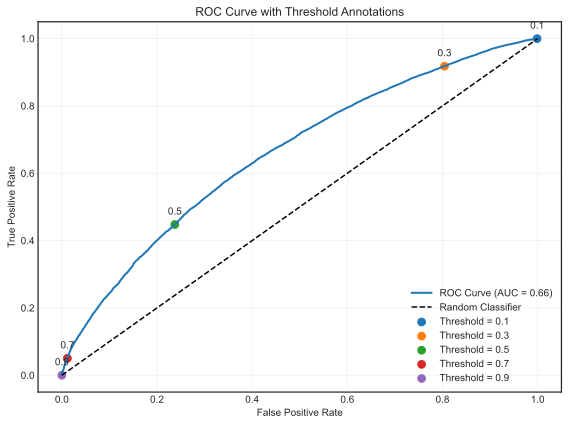

In [359]:
plot_roc_with_thresholds(val_preds_df['actual'], val_preds_df['yhat_proba'])

Common interpretation of the performance of a classifier with respect to a random classifier is as follows: 

- Bad Model: If `AUC` under `ROC` : 0.5 - 0.6
- Poor Model: If `AUC` under `ROC` : 0.6 - 0.7
- Fair Model: If `AUC` under `ROC` : 0.7 - 0.8
- Good Model: If `AUC` under `ROC` : 0.8 - 0.9
- Excellent Model: If `AUC` under `ROC` : 0.9 - 1.

To improve the model, we need to go back and deal with outliers and/or generate interactions terms that have better predictive power as implied by their `IV`, some interaction terms that could be useful are noted below for reference: 

| Variable 1        | Variable 2       | Rationale                                         |
|------------------|------------------|----------------------------------------------------|
| `dti`            | `annual_inc`     | Affordability + debt level                         |
| `emp_length`     | `home_ownership` | Stability + asset ownership                        |
| `inq_last_6mths` | `dti`            | Aggressive credit seeking + obligations            |
| `purpose`        | `annual_inc`     | Reason for loan + income level                     |
| `revol_util`     | `tot_cur_bal`    | Usage of revolving credit vs total debt            |


#### Gini and Kolmogorov-Smirnov Coefficients for model evaluation
----

Similar to `ROC` and `AUC` there are two more widely accepted and used criterions for the performance of the classifier within the context of Credit Risk: 

1. **Gini Coefficient:** Originally invented to measure the inequality between rick and poor individuals in an economy. Here it does serve the purpose of distinguishing good and bad borrowers. Pretty similar to the `AUC` for the `ROC`. In particular, it measures the cumulative % of defaulted borrowers as a function of the cumulative % of all borrowers. Note that the borrowers should be arranged in ascending order of probability of being "good".
   
2. **Kolmogorov-Smirnov coefficient:** Measures the maximum distance between the cumulative distribution functions of `good` and `bad` borrowers!. The more the distance the better the model in distinguishing these classes/random variables! 

In [587]:
# first drop the unnecessary column of predictions with the default threshold \neq 0.5
val_preds_df.drop('yhat_thr0p6', axis = 1, inplace = True)

val_preds_df = val_preds_df.sort_values('yhat_proba')

val_preds_df.head(10)

,actual,yhat,yhat_proba
58859,0,0,0.065400
36543,1,0,0.070651
30068,0,0,0.075932
35261,1,0,0.079633
49722,1,0,0.081055
49971,1,0,0.081127
83996,1,0,0.083505
80633,0,0,0.083791
57377,0,0,0.083997
8746,0,0,0.085924


In [588]:
# indexes are shuffled, we need them back in order of increasing from lowest prob to highest prob

val_preds_df = val_preds_df.reset_index()

val_preds_df.head(10)

,index,actual,yhat,yhat_proba
0,58859,0,0,0.065400
1,36543,1,0,0.070651
2,30068,0,0,0.075932
3,35261,1,0,0.079633
4,49722,1,0,0.081055
5,49971,1,0,0.081127
6,83996,1,0,0.083505
7,80633,0,0,0.083791
8,57377,0,0,0.083997
9,8746,0,0,0.085924


To compute Gini and K-S we need to cumulative percentage of total population, good and bad borrowers. We first count the cumulative number of borrowers within and up to a given probability `yhat_proba`: 

In [589]:
val_preds_df['cum_num_total'] = val_preds_df.index + 1
val_preds_df['cum_num_non_default'] = val_preds_df['actual'].cumsum() # 1's are non-defaults
val_preds_df['cum_num_default'] = val_preds_df['cum_num_total'] - val_preds_df['actual'].cumsum()

Cumulative percentages is then simply derived via dividing total numbers in each category: 

In [590]:
val_preds_df['cum_pct_total'] = val_preds_df['cum_num_total'] / val_preds_df.shape[0]
val_preds_df['cum_pct_non_default'] = val_preds_df['cum_num_non_default'] / val_preds_df['actual'].sum()
val_preds_df['cum_pct_default'] = val_preds_df['cum_num_default'] / (val_preds_df.shape[0] - val_preds_df['actual'].sum())

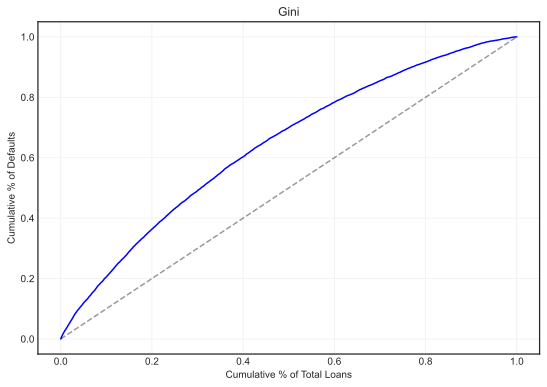

In [591]:
plt.figure(figsize=(9, 6))

plt.plot(val_preds_df['cum_pct_total'], val_preds_df['cum_pct_default'], label='Cumulative Non-Defaults', color='blue')
plt.plot(val_preds_df['cum_pct_total'], val_preds_df['cum_pct_total'], color='k', ls = '--', alpha  = 0.4)
plt.title('Gini')

plt.xlabel('Cumulative % of Total Loans')
plt.ylabel('Cumulative % of Defaults')
plt.grid(alpha = 0.3)

Gini coefficient is the area between the diagonal and the curve, divided by the area above the diagonal! Recall that `AUC` was the area under the curve divided by the total area of the square!

The connection with `AUC` is clear from the plot: calling the area between the diagonal and the curve A and the area above the curve B. 

$$
\textrm{AUC} = \frac{2 A + B}{2(A+B)} \quad\quad \textrm{Gini} = \frac{A}{A+B}, \quad\quad \longrightarrow \quad\quad \textrm{AUC} = \frac{1 + \textrm{Gini}}{2}
$$

This gives 

$$
\textrm{Gini} = 2 \textrm{AUC} - 1
$$

In [592]:
gini = 2. * auc_score- 1.

gini

0.3170818788664076

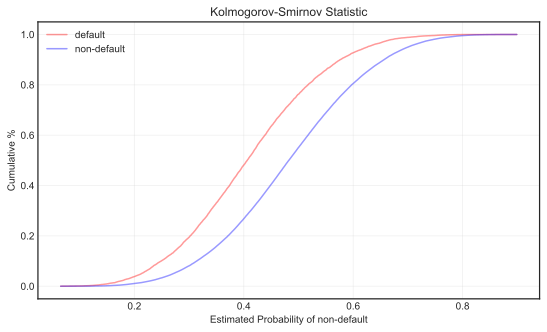

In [593]:
# Kolmogorov-Smirnow statistic 

plt.figure(figsize=(9, 5))

plt.plot(val_preds_df['yhat_proba'], val_preds_df['cum_pct_default'], color = 'red', alpha = 0.4, label = 'default')
plt.plot(val_preds_df['yhat_proba'], val_preds_df['cum_pct_non_default'], color='blue', alpha  = 0.4, label = 'non-default')
plt.title('Kolmogorov-Smirnov Statistic')

plt.legend()
plt.xlabel('Estimated Probability of non-default')
plt.ylabel('Cumulative %')
plt.grid(alpha = 0.3)

In [594]:
KS = np.max(val_preds_df['cum_pct_default'] - val_preds_df['cum_pct_non_default'])

KS

0.23180153604088438

Perfect model has KS = 1 whereas a random classifier has KS = 0!

#### Creating Scorecards from the PD model and vice versa 
-------

Given that we have a model that we can use to understand the probability of default of a borrower, we can turn this into a more standardized interpretable scorecards instead of talking about less understandable model coefficients, which in the end allow us to infer the odds of default/non-default when a borrower has the characteristic corresponding to that coefficient. Of course some other borrower might not have that characteristic, which affects its PD relative to the former borrower. Scorecards are useful to make this relative stance by quantifying PD in terms of scores between a pre-defined range. For example FICO generally turn the estimates of their PD model into scorecards within 350-800 range in order to assess the credit worthiness of individuals. 

In [623]:
coefficients_df = lr_model.coef_summary()

coefficients_df = coefficients_df.drop('P-Value', axis = 1)

model_df = coefficients_df[1:].sort_values('Variable')

model_df = pd.concat([coefficients_df.iloc[0:1], model_df])

model_df

,Coefficient
Variable,
const,-1.672207
addr_state:AR-MI-PA-OH,0.110138
addr_state:AZ-NJ,0.043827
addr_state:CA-UT-KY,0.044299
addr_state:GA-WA-OR-WI,0.133024
addr_state:IL-CT,0.176802
addr_state:KS-SC-CO-VT-AK-MS-WV-NH-WY-DC-ME-ID,0.248863
addr_state:LA-MD-NC,0.035000
addr_state:MN-RI-MA-DE-SD-IN,0.079405


For any borrower, only 1 of the category within the original variable, e.g `tot_cur_bal`, `addr_state` etc. Furthermore, recall that the model coefficients above is defined with reference to another base categories. Essentially this means that these reference categories have zero coefficients. We add them for the full transparency of the scorecard. 

In [ ]:
reference_cats_df = pd.DataFrame({'Variable':reference_cols, 'Coefficient':[0]*len(reference_cols)})

reference_cats_df.set_index('Variable', inplace=True)

model_df = pd.concat([model_df, reference_cats_df])

intercept_df = model_df.iloc[0:1]

model_df = model_df.iloc[1:].sort_values('Variable')


In [626]:
model_df = pd.concat([intercept_df, model_df])

model_df

,Coefficient
Variable,
const,-1.672207
addr_state:AR-MI-PA-OH,0.110138
addr_state:AZ-NJ,0.043827
addr_state:CA-UT-KY,0.044299
addr_state:GA-WA-OR-WI,0.133024
addr_state:IL-CT,0.176802
addr_state:KS-SC-CO-VT-AK-MS-WV-NH-WY-DC-ME-ID,0.248863
addr_state:LA-MD-NC,0.035000
addr_state:MN-RI-MA-DE-SD-IN,0.079405
